## Установка зависимостей

In [1]:
%pip install pandas matplotlib seaborn openpyxl faker

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [2]:
from datetime import datetime, timedelta
from faker import Faker 
import pandas as pd
import csv
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import random
import openpyxl
from scipy.stats import mode
import seaborn as sns

<span style="color: yellow">
Старайся удалять импорт неиспользуемых библиотек.
С этим могут помочь линтеры, например <strong>flake8, pylint</strong>
</span>

### Настройка окружения

In [3]:
fake = Faker()
sns.set_style("darkgrid")

## Обзор данных

In [4]:
dt_specie = pd.read_excel("/home/barry/Documents/PythonProjects/Test/specie_data.xlsx")

In [5]:
dt_specie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         75 non-null     object 
 1   Adult height    75 non-null     float64
 2   Child's height  75 non-null     float64
 3   Adult weight    75 non-null     float64
 4   Child's weight  75 non-null     float64
 5   Lifespan        75 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.6+ KB


In [6]:
dt_specie.head(5)

,Species,Adult height,Child's height,Adult weight,Child's weight,Lifespan
0,Chinese Alligator,220.0,44.0,45.00,4.500,50
1,Venezuelan Amazon,41.0,8.2,0.34,0.034,60
2,Yellow-faced Amazon,37.0,7.4,0.34,0.034,50
3,Blue-faced Amazon,54.5,10.9,0.52,0.052,70
4,White-tailed wildebeest,120.0,24.0,170.00,17.000,20


In [7]:
dt_specie.tail(5)

,Species,Adult height,Child's height,Adult weight,Child's weight,Lifespan
70,Gorilla,170.0,100.0,200.0,13.0,35
71,Aquila,70.0,30.0,5.0,2.0,15
72,Macropodidae,200.0,40.0,50.0,3.0,50
73,Equus zebra,200.0,80.0,400.0,20.0,30
74,Giraffa camelopardalis,500.0,200.0,1200.0,100.0,40


In [8]:
dt_specie.describe()

,Adult height,Child's height,Adult weight,Child's weight,Lifespan
count,75.00000,75.000000,75.000000,75.000000,75.000000
mean,115.70000,27.646667,112.260733,7.739407,28.720000
std,85.45858,30.840366,536.377493,26.439330,17.620289
min,23.00000,4.600000,0.125000,0.012500,3.000000
25%,60.00000,11.600000,1.000000,0.100000,15.000000
50%,90.00000,18.000000,3.500000,0.350000,25.000000
75%,145.00000,29.000000,40.000000,3.500000,40.000000
max,500.00000,200.000000,4500.000000,200.000000,80.000000


### Вывод

Взрослый Рост
- Среднее: 115.7
- Медиана: 90.0
- Скос: Среднее больше медианы, что указывает на правую асимметрию распределения.

Рост Ребенка
- Среднее: 27.65
- Медиана: 18.0
- Скос: Среднее больше медианы, указывая на правую асимметрию.

Взрослая Масса Тела:
- Среднее: 112.26
- Медиана: 3.5
- Скос: Среднее больше медианы, что указывает на правую асимметрию. Однако наличие нескольких очень высоких значений может влиять на среднее.

Масса Тела Ребенка:
- Среднее: 7.74
- Медиана: 0.35
- Скос: Среднее больше медианы, указывая на правую асимметрию. Аналогично взрослой массе тела, наличие нескольких очень высоких значений может влиять на среднее.

Продолжительность Жизни:
- Среднее: 28.72
- Медиана: 25.0
- Скос: Среднее больше медианы, указывая на правую асимметрию.

<span style="color: yellow">
В последнем пункте о продолжительности жизни скошенности скорее всего нет. Хотя медиана и среднее различаются, тем не менее, значения относительно близкие.
</span>

# Создание класса итератора

In [1]:
class AnimalRowGenerator:
    def __init__(self,species,n_animals):
        self._species = species
        self._n_animals = int(n_animals)
        self._state_species = 0
        self._state_cur_animals = 0

    def __iter__(self):
        return self

    def __next__(self):

        gender = self.gen_gender()
        birthday = self.gen_birthday()   
        maturity = self.gen_maturity(birthday)
        weight = self.gen_weight(maturity)
        height = self.gen_height(maturity)
        name = self.gen_name()
        
        row = [name,birthday.strftime('%Y-%m-%dT%H:%M:%S') ,self._species["Species"][self._state_species],maturity, weight, height , gender]

        
        self.update_state()

        return row
        

    def update_state(self):
        if self._state_cur_animals == self._n_animals:            
            if self._state_species == len(self._species) - 1:
                self._state_cur_animals = 0
                self._state_species = 0
            else:
                self._state_cur_animals = 0
                self._state_species += 1
        else:
            self._state_cur_animals += 1
 
    def generate_date(self,start_date):
        return fake.date_time_between(start_date=start_date, end_date=datetime.now())
    
    def gen_gender(self):
        numb = random.randint(1, 100)
        if numb >= 40:
            return 'Male'
        else:
            return 'Female'

    def gen_name(self):
        return fake.name()

    def gen_maturity(self, birthday):
        lifespan = self._species['Lifespan'][self._state_species]
        difference = (datetime.now() - birthday).days / 365 
        maturity = difference > 0.3 * lifespan
        return maturity
    
    def gen_birthday(self):
        return self.generate_date(datetime.now() - timedelta(days=365.25 * self._species['Lifespan'][self._state_species]) )
        
    def gen_weight(self, maturity) -> bool:
        if maturity:
            return round(random.uniform(self._species["Child's weight"][self._state_species], 
                                        self._species['Adult weight'][self._state_species]), 2)
        else:
            return round(random.uniform(1.0, self._species["Child's weight"][self._state_species]), 2)   
            
    def gen_height(self, maturity):
        if maturity:
            return round(random.uniform(self._species["Child's height"][self._state_species], 
                                        self._species['Adult height'][self._state_species]), 2)
        else:
            return round(random.uniform(1.0, self._species["Child's height"][self._state_species]), 2)        

<span style="color: green">
Отлично орагнизовал генератор!
</span>

# Генерация данных

In [10]:
n_animals = 7
animal_generator = AnimalRowGenerator(dt_specie, n_animals)

<span style="color: yellow">
<ul>
    <li>Параметры в ячейке ниже, будет хорошим тоном, вынести вверх к настройкам окружения. </br>
Так все настройки будут лежать в одной куче и их не надо искать по всему проекту (даже тут проявляются High Cohesion, Information Expert) </br>
Cell - объект, настройки - поля объекта...</li>
    <li>Параметр num_rows мог быть парметром генератора</li>
<ul>
</span>

In [11]:
your_path = '/home/barry/Documents/DataTest/'
num_rows = 490

In [12]:
def create_file(file_path, header,  num_rows):
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        workbook = writer.book
        worksheet = workbook.add_worksheet()
        worksheet.write_row(0, 0, header)
        for i in range(num_rows): # Здесь еще можно задавать начало и шаг range(start=2, stop=num_rows+1, step=2) - четные числа начиная с двойки
            row_data = animal_generator.__next__() # Этот вызов делается так: next(animal_generator)
            worksheet.write_row(i + 1, 0, row_data)


<span style="color: yellow">
<p>
Что будешь делать, если в функции create_file попросят использовать другой генератор строк? </br>
А если генератора в глобальном пространстве еще не создали? </br>
Такое неявное использование объектов может запутать и привести к ошибкам - лучше передавать его как аргумент. </p>
<p>
В python есть встроенная функция enumerate(Iterable).  </br>
Если в генератор включить параметр num_rows то можно было бы делать так:
</p>
</span>

```python
for i, row in enumerate(animal_generator, start=1):
    worksheet.write_row(i, 0, row_data)
```


In [13]:
animals_file_path = your_path + 'Animval.xlsx'
create_file(animals_file_path, ["Кличка", "Дата появления", "Вид","Зрелость", "Вес", "Рост", "Пол"], num_rows)

### Обзор данных

In [14]:
dt_gd = pd.read_excel("/home/barry/Documents/DataTest/Animval.xlsx")


In [15]:
dt_gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Кличка          490 non-null    object 
 1   Дата появления  490 non-null    object 
 2   Вид             490 non-null    object 
 3   Зрелость        490 non-null    int64  
 4   Вес             490 non-null    float64
 5   Рост            490 non-null    float64
 6   Пол             490 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 26.9+ KB


In [16]:
dt_gd.head(3)

,Кличка,Дата появления,Вид,Зрелость,Вес,Рост,Пол
0,Miss Angela James,1998-10-15T14:10:42,Chinese Alligator,1,11.18,156.29,Male
1,Jeff Peterson,1997-07-15T01:37:53,Chinese Alligator,1,39.77,203.89,Male
2,Robert Hahn,2002-06-13T19:20:06,Chinese Alligator,1,19.42,175.30,Male


In [17]:
dt_gd.tail(3)

,Кличка,Дата появления,Вид,Зрелость,Вес,Рост,Пол
487,Theresa Stokes,2021-10-07T08:17:07,Blackbird,1,0.10,18.17,Male
488,Samantha Taylor,2022-05-18T22:55:43,White-breasted hedgehog,1,0.52,19.67,Male
489,Jeffery Caldwell,2022-10-14T21:30:13,White-breasted hedgehog,1,0.56,25.88,Female


## Анализ данных

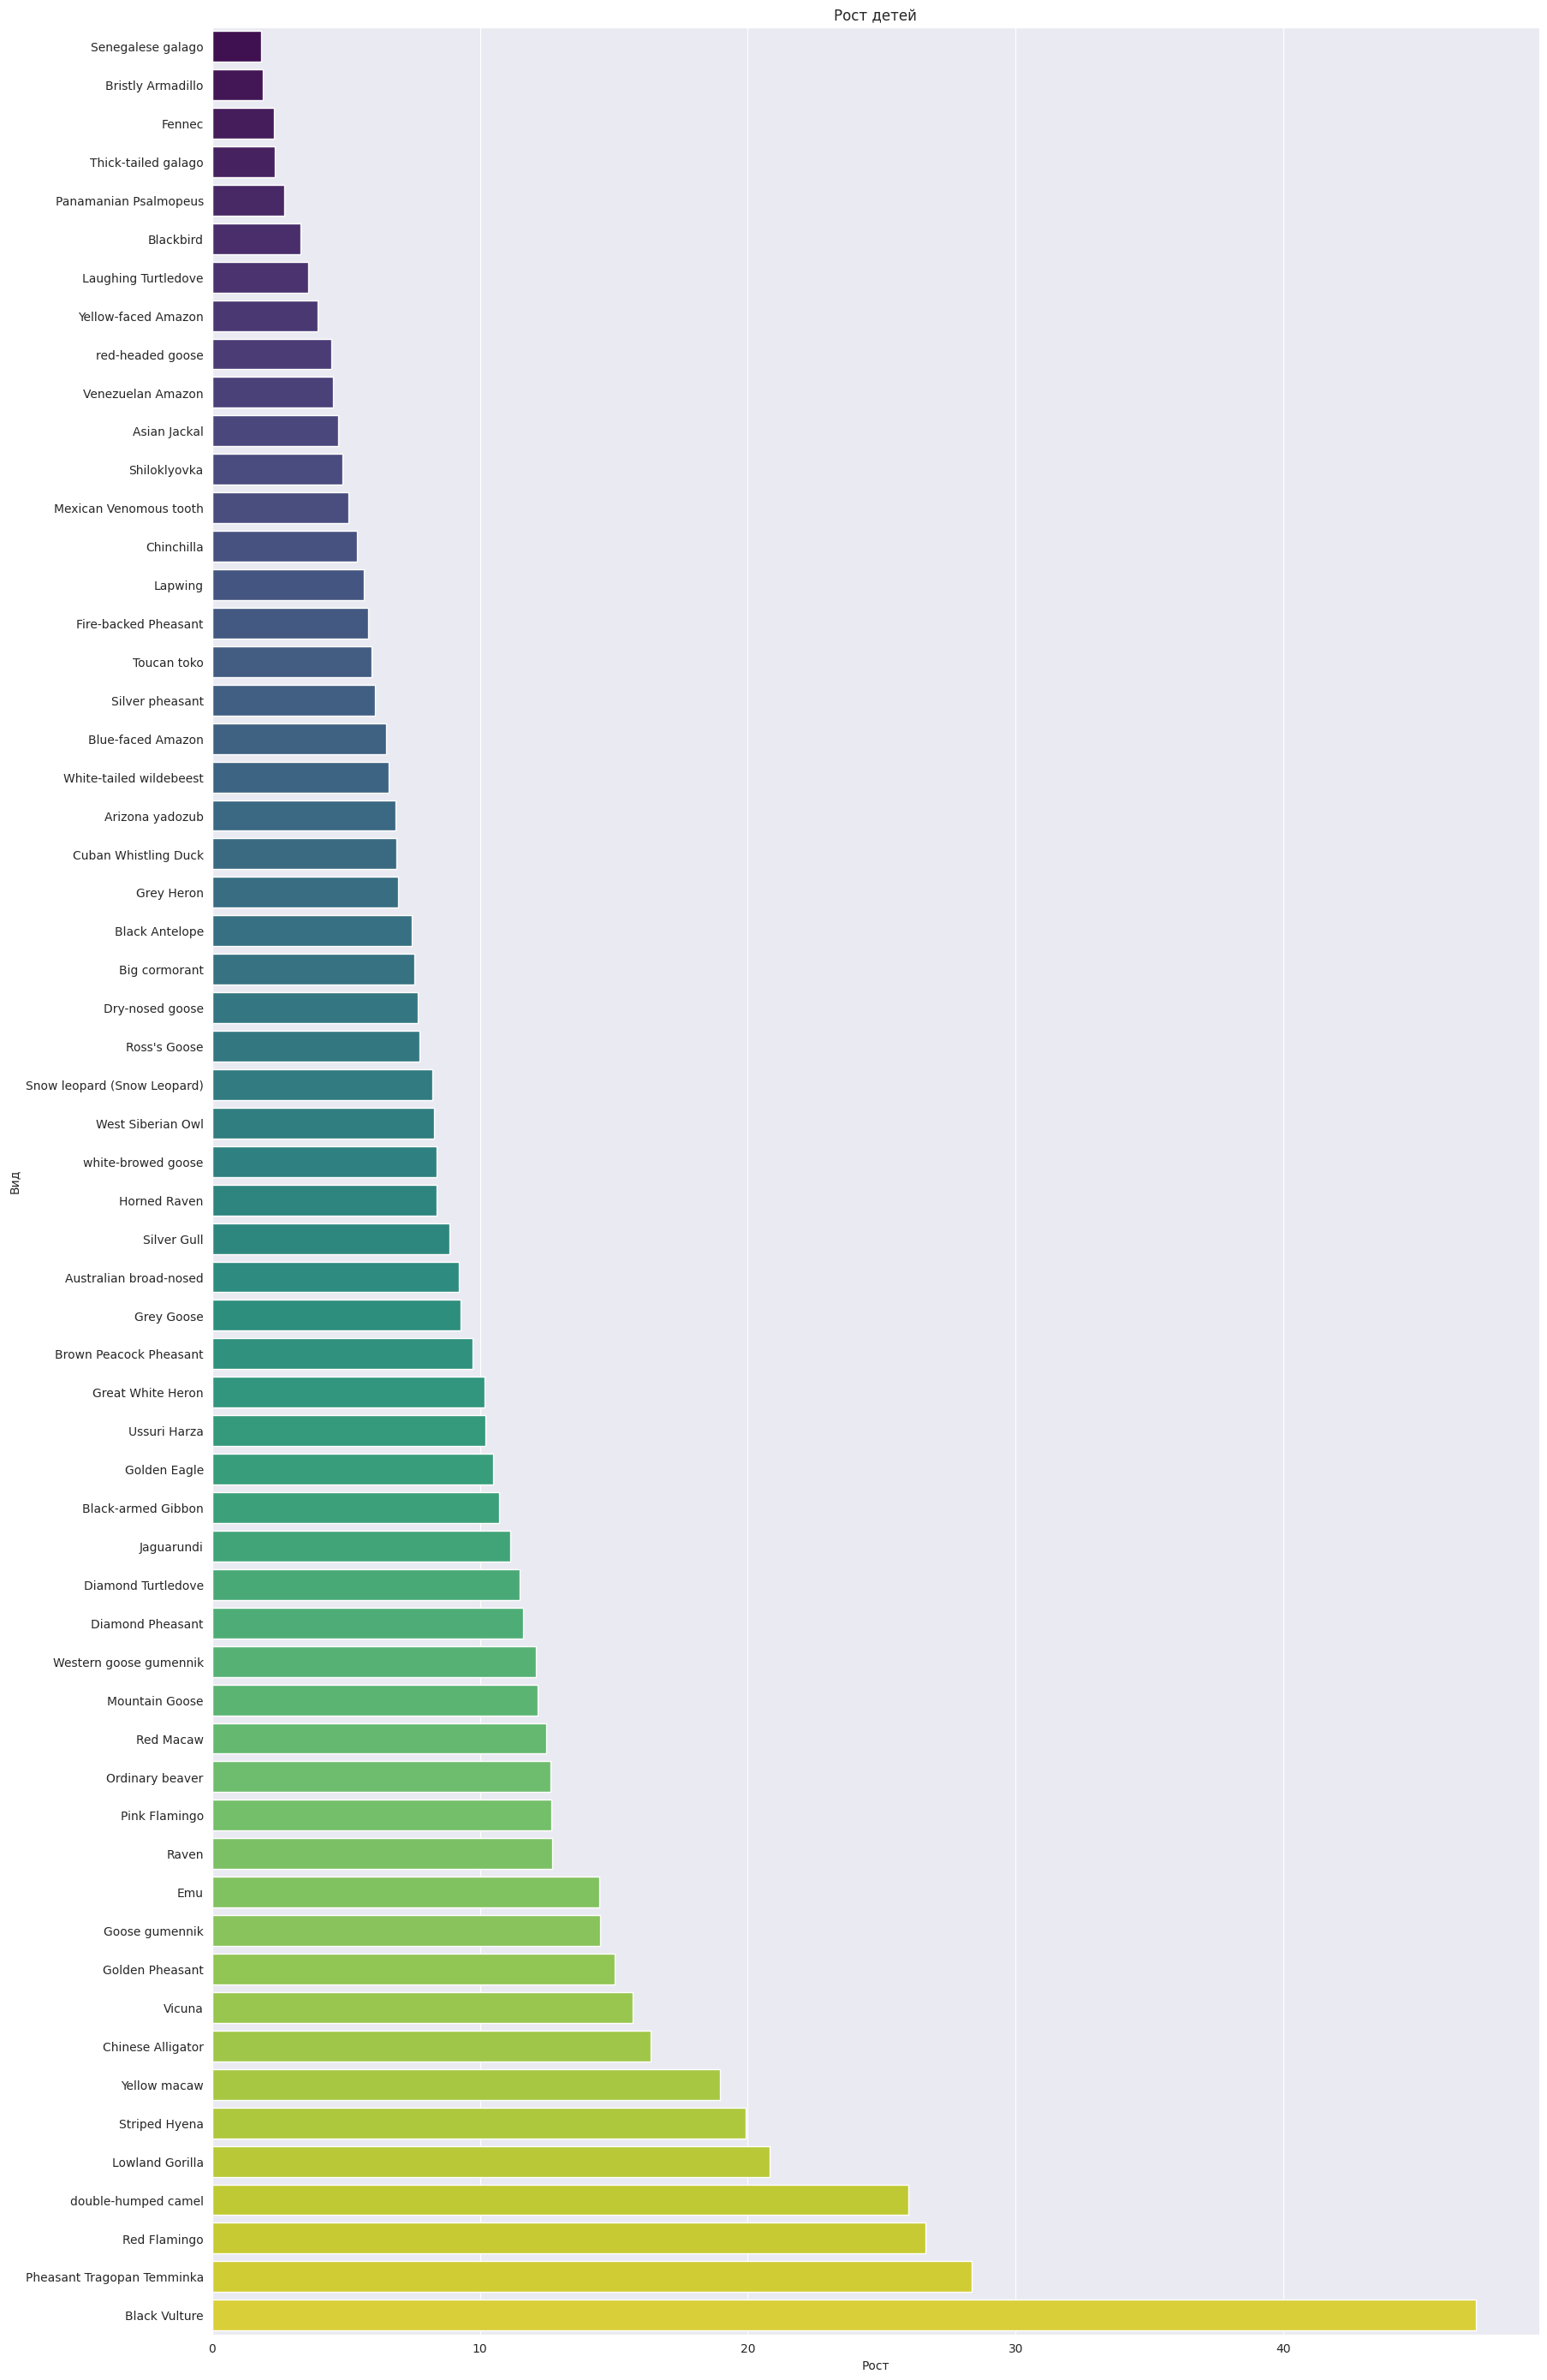

In [18]:
dt_gd_child = dt_gd[dt_gd['Зрелость'] == False]

dt_gd_child_mean = dt_gd_child.groupby('Вид')['Рост'].mean().reset_index()

mean_height_by_species_sorted = dt_gd_child_mean.sort_values(by='Рост')

plt.figure(figsize=(20, 35))
sns.barplot(x='Рост', y='Вид', hue='Вид', data=mean_height_by_species_sorted, palette='viridis', legend=False)
plt.xlabel('Рост')
plt.ylabel('Вид')
plt.title('Рост детей')
plt.show()


<span style="color: yellow">
Сразу видно, что в зоопарке чёрных грифов кормят хорошо)) </br>
50-метровые птенцы еще подрастут и будут привлекать большое количество посетителей </br>
Как они только этого добились?))

Если в сортировку добавить параметр ascending=False, наибольший рост будет сверху. А ограничить вывод можно списочным срезом <strong>mean_height_by_species_sorted[:10]</strong> - top 10 самых больших зверенышей
</span>

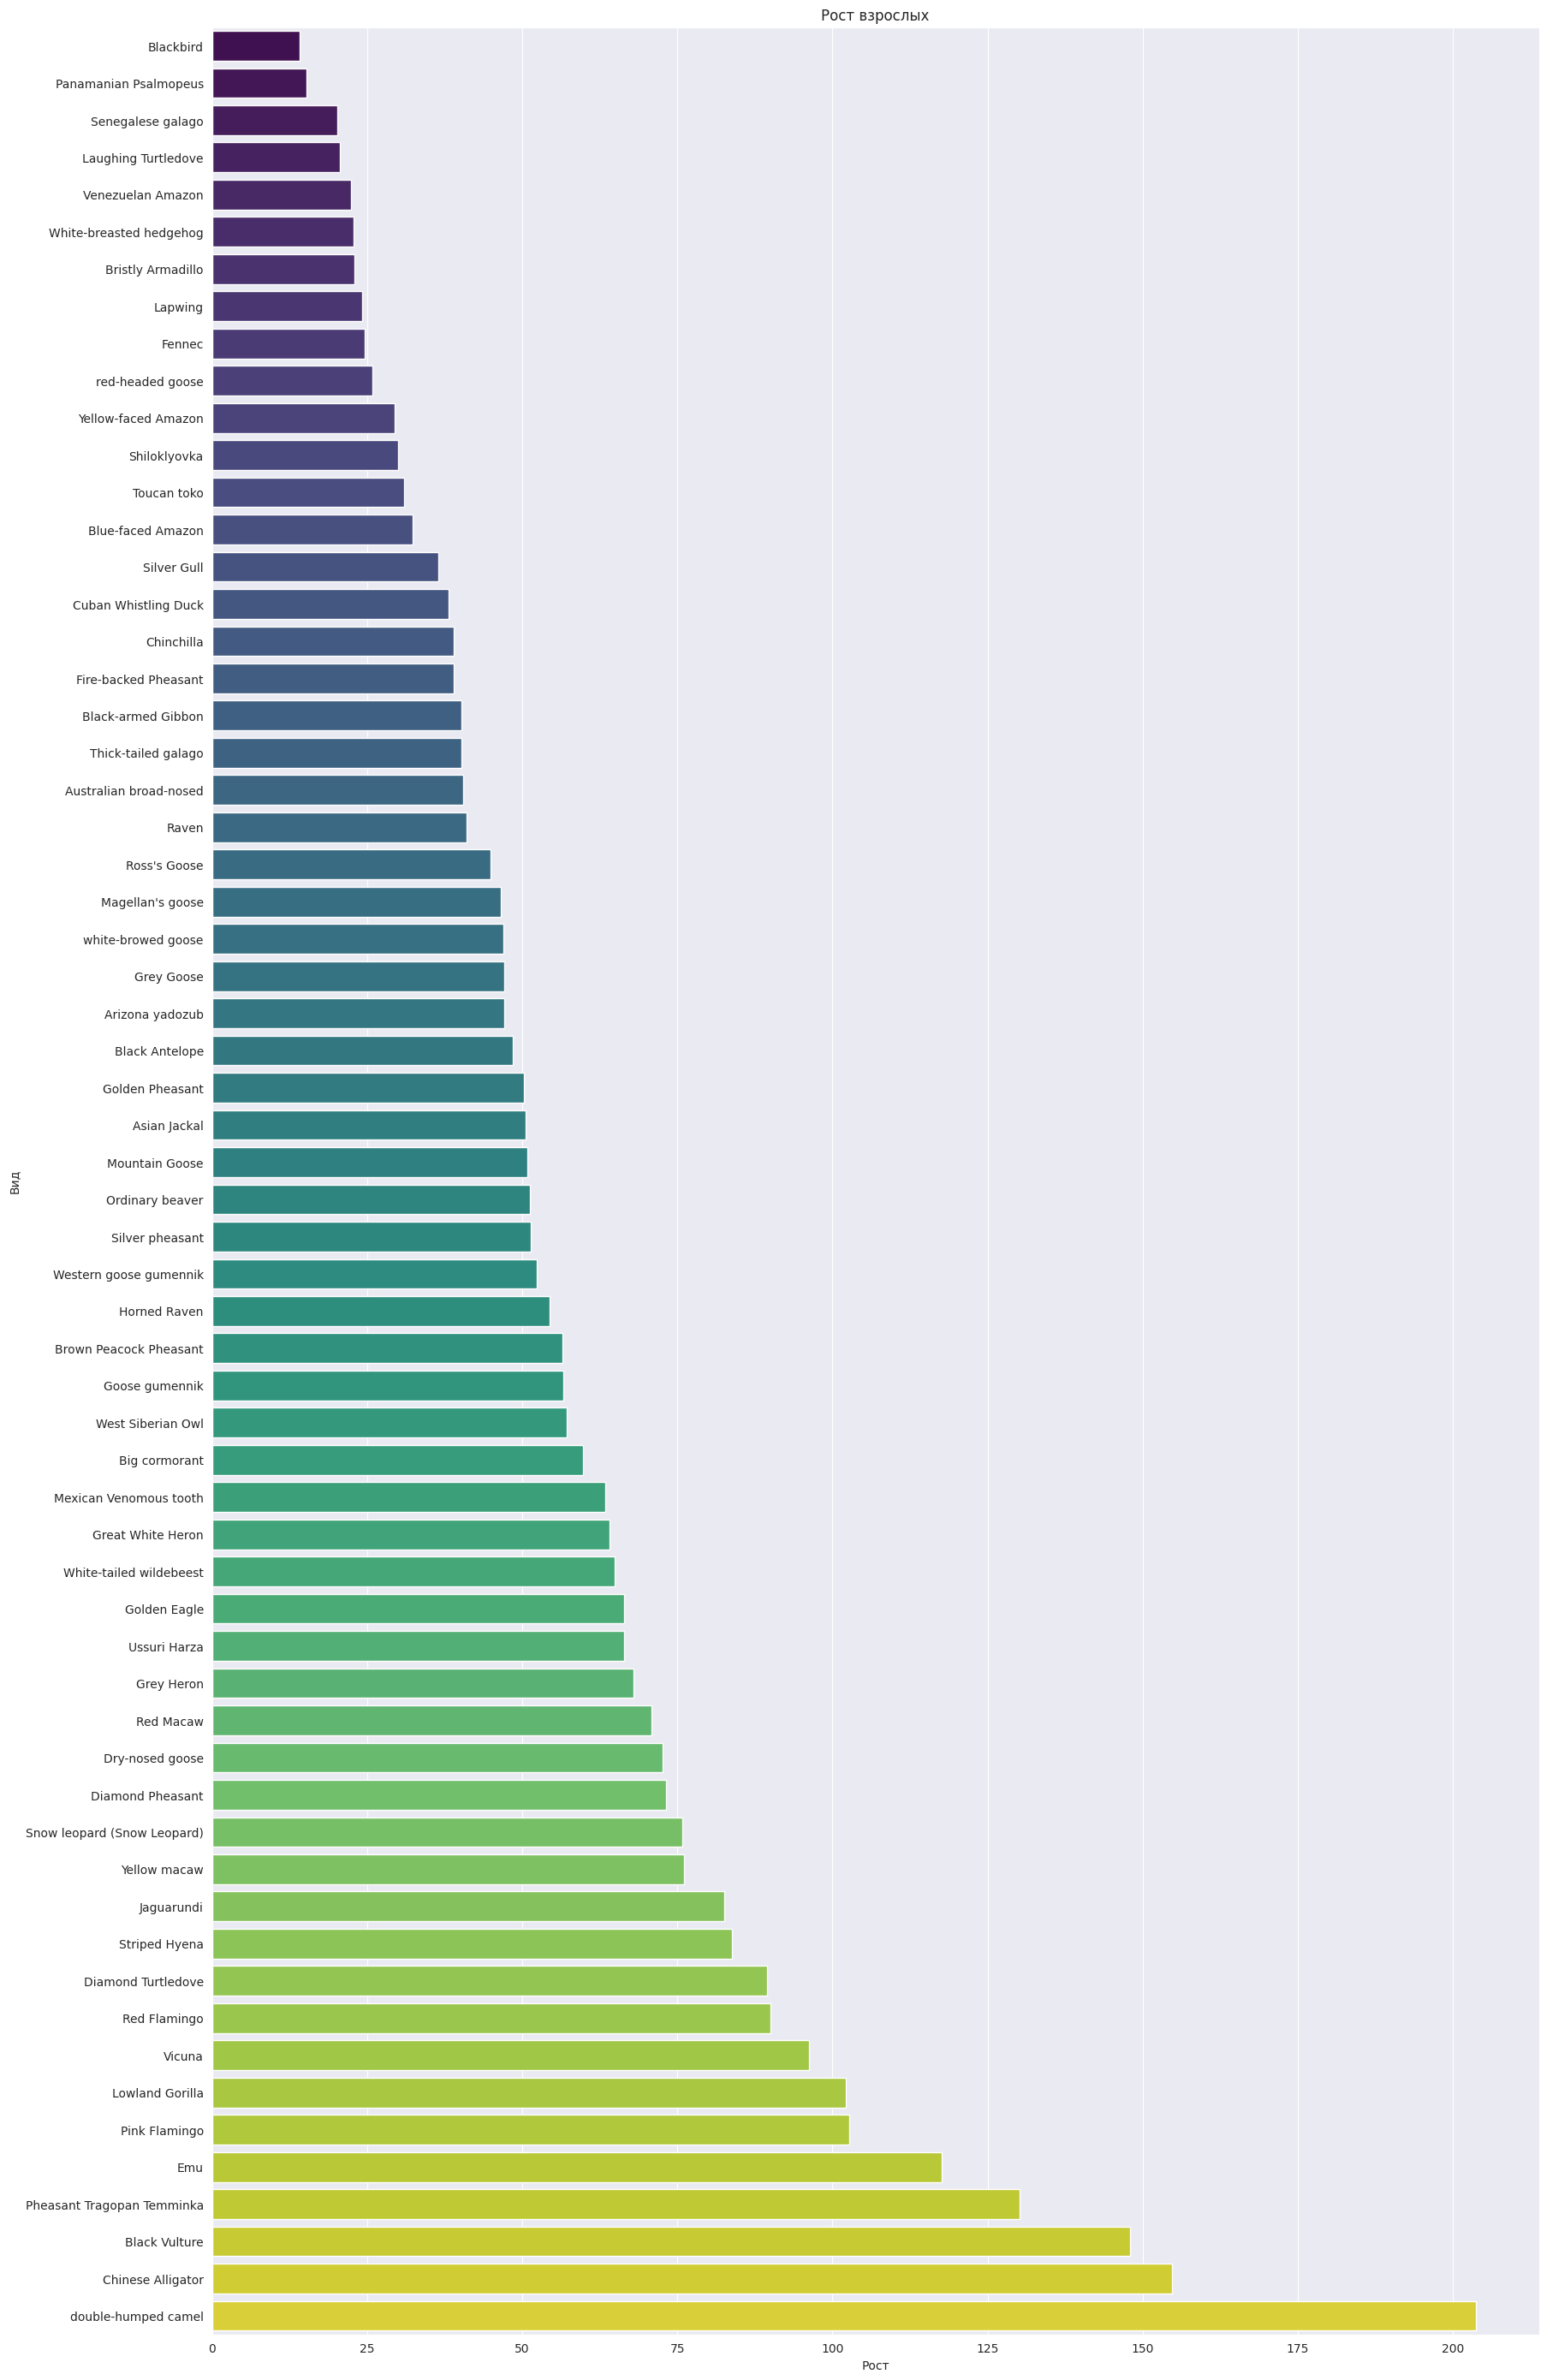

In [19]:
dt_gd_adult = dt_gd[dt_gd['Зрелость'] == True]

dt_gd_adult_mean = dt_gd_adult.groupby('Вид')['Рост'].mean().reset_index()

mean_height_by_species_sorted = dt_gd_adult_mean.sort_values(by='Рост')

plt.figure(figsize=(20, 35))
sns.barplot(x='Рост', y='Вид', hue='Вид', data=mean_height_by_species_sorted, palette='viridis', legend=False)
plt.xlabel('Рост')
plt.ylabel('Вид')
plt.title('Рост взрослых')
plt.show()


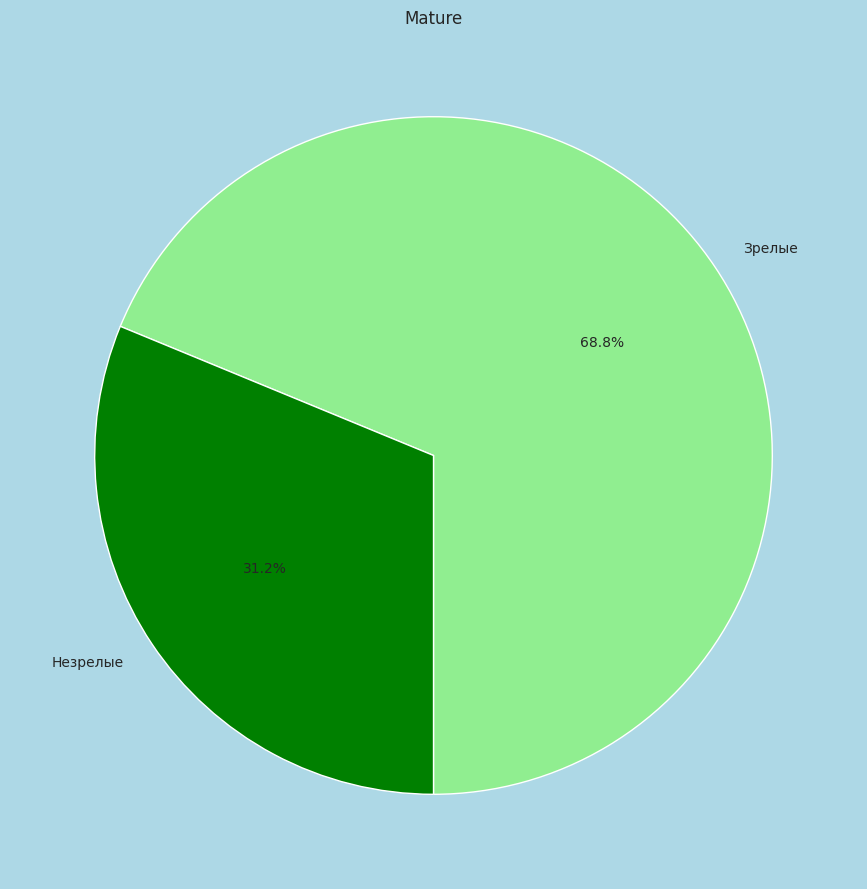

In [20]:
mature_counts = dt_gd['Зрелость'].value_counts()

label_mapping = {1: 'Зрелые', 0: 'Незрелые'}
mature_counts.index = mature_counts.index.map(label_mapping)
plt.figure(figsize=(11, 11), facecolor='lightBlue')
plt.pie(mature_counts, labels=mature_counts.index, autopct='%1.01f%%', startangle=270, colors=['LightGreen', 'green'])
plt.title('Mature')
plt.show()

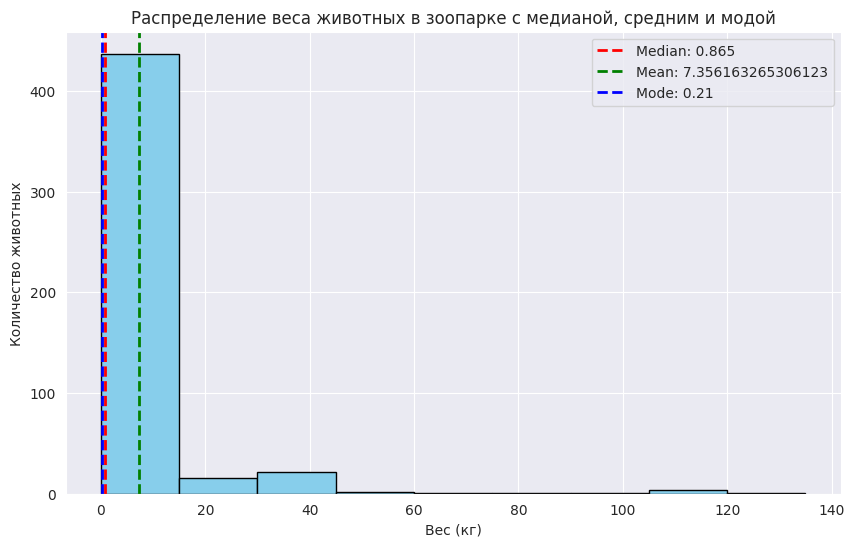

In [21]:

weights = dt_gd['Вес']


plt.figure(figsize=(10, 6))
plt.hist(weights, bins=[0, 15, 30, 45, 60, 75, 90, 105, 120, 135], color='skyblue', edgecolor='black')  


median_weight = np.median(weights)
plt.axvline(median_weight, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_weight}')


mean_weight = np.mean(weights)
plt.axvline(mean_weight, color='green', linestyle='dashed', linewidth=2, label=f'Mean: {mean_weight}')


mode_result = stats.mode(weights)
mode_weight = np.atleast_1d(mode_result.mode)[0] if np.atleast_1d(mode_result.mode).size > 0 else None

if mode_weight is not None:
    plt.axvline(mode_weight, color='blue', linestyle='dashed', linewidth=2, label=f'Mode: {mode_weight}')


plt.legend()


plt.title('Распределение веса животных в зоопарке с медианой, средним и модой')
plt.xlabel('Вес (кг)')
plt.ylabel('Количество животных')
plt.show()

In [22]:
dt_gd.describe()

,Зрелость,Вес,Рост
count,490.000000,490.000000,490.000000
mean,0.687755,7.356163,45.013694
std,0.463883,21.938542,44.183873
min,0.000000,0.030000,1.030000
25%,0.000000,0.412500,12.482500
50%,1.000000,0.865000,33.875000
75%,1.000000,2.800000,60.695000
max,1.000000,194.680000,301.580000


## Вывод

Оба параметра "Вес" и "Рост" имеют правую асимметрию, что может быть вызвано наличием выбросов или экстремальных значений в данных

<span style="color: yellow">
Дополни вывод анализом графиков. Иначе зачем их рисовал?
</span>